In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
all_data = pd.read_csv("data/INFLU20-04052020.csv", sep=';', encoding = "ISO-8859-1")
OHE = True

In [3]:
# COVID-19 patients
all_data = all_data[all_data['PCR_SARS2']==1]
all_data.shape

(19940, 138)

In [4]:
### Remove patients without ethnicity recorded
all_data = all_data[~all_data['CS_RACA'].isnull()]
all_data = all_data[all_data['CS_RACA']!=9]
all_data.shape

(12221, 138)

In [5]:
### Keep only hospitalized patients
hospitalized_patients = all_data[(all_data['HOSPITAL']==1)]
hospitalized_patients.shape

(11321, 138)

## Data pre-processing

In [6]:
translate = {'NU_IDADE_N': 'Age', 'CS_SEXO': 'Sex', 'EVOLUCAO':'Evolution', 'CS_RACA':'Race',
              
             # Symptomps
             'FEBRE':'Fever', 'TOSSE': 'Cough', 'GARGANTA': 'Sore_throat', 
             'DISPNEIA':'Shortness_of_breath', 'DESC_RESP':'Respiratory_discomfort', 'SATURACAO':'SPO2',  
             'DIARREIA':'Dihareea', 'VOMITO':'Vomitting', 
             
             # Comorbidities
             'CARDIOPATI': 'Cardiovascular', 'HEPATICA': 'Liver', 'ASMA': 'Asthma', 
             'DIABETES': 'Diabetis', 'NEUROLOGIC': 'Neurologic', 'PNEUMOPATI': 'Pulmonary',
             'IMUNODEPRE': 'Immunosuppresion', 'RENAL':'Renal', 'OBESIDADE': 'Obesity',
            
             # Interventions
             'TP_ANTIVIR': 'Antiviral_type',
             #'OUT_ANTIV': 'Antivirals_other', 
             # 'SUPORT_VEN': 'Vent_Support',
             
             # Departments
             'DT_INTERNA': 'Hosp_DT',
             'DT_ANTIVIR': 'Antiviral_start_DT',
             # 'UTI': 'ICU',
             'DT_ENTUTI': 'ICU_Admission_DT',
             # 'DT_SAIDUTI': 'ICU_Discharge_DT'
            }
hospitalized_patients = hospitalized_patients.rename(columns=translate)

In [7]:
demographics = ['Age', 'Sex', 'Race', 'SG_UF_NOT']

symptoms = ['Fever','Cough', 'Sore_throat', 'Shortness_of_breath', 'Respiratory_discomfort', 'SPO2', 'Dihareea', 'Vomitting']

comorbidities = ['Cardiovascular',  'Asthma', 'Diabetis', 'Pulmonary', 'Immunosuppresion',
                 'Obesity', 'Liver', 'Neurologic', 'Renal']

outcome = ['Evolution']

races = ['Branca', 'Preta', 'Amarela', 'Parda', 'Indigena']

areas = ['Northeast', 'North', 'Southeast', 'Central-West', 'South']

event_dates = [
               # 'DT_SIN_PRI', 'DT_COLETA', 'DT_PCR', 'DT_ENCERRA'
               'Hosp_DT', 'Antiviral_start_DT', 'ICU_Admission_DT', 
               'DT_EVOLUCA', # Date of discharge or death (outcome)
               ]

interventions = ['Antiviral_med', 'Vent_invasive', 'Vent_noninvasive', 'FLU_Vaccine']

age_groups = ['Age_40', 'Age_40_50', 'Age_50_60', 'Age_60_70', 'Age_70']

In [8]:
# Encode race
race_encoding = {1.0: 'Branca', 2.0:'Preta', 3.0:'Amarela', 4.0:'Parda', 5.0: 'Indigena'}
hospitalized_patients['Race'] = hospitalized_patients['Race'].apply(lambda i: race_encoding[i])

if OHE:
    for race in races:
        hospitalized_patients[race] = (hospitalized_patients['Race'] == race).astype(np.int32)

In [9]:
# Encode ages
hospitalized_patients['Age_40'] = (hospitalized_patients['Age'] < 40).astype(np.int32)
hospitalized_patients['Age_40_50'] = ((hospitalized_patients['Age'] >= 40) &  (hospitalized_patients['Age'] < 50)).astype(np.int32)
hospitalized_patients['Age_50_60'] = ((hospitalized_patients['Age'] >= 50) &  (hospitalized_patients['Age'] < 60)).astype(np.int32)
hospitalized_patients['Age_60_70'] = ((hospitalized_patients['Age'] >= 60) &  (hospitalized_patients['Age'] < 70)).astype(np.int32)
hospitalized_patients['Age_70'] = (hospitalized_patients['Age'] >= 70).astype(np.int32)

In [10]:
for event_date in event_dates:
    hospitalized_patients[event_date] = pd.to_datetime(hospitalized_patients[event_date], format="%d/%m/%Y")

In [11]:
if OHE:
    hospitalized_patients['Sex_male'] = (hospitalized_patients['Sex'] == 'M').astype(np.int32)
# hospitalized_patients['is_dead'] = (hospitalized_patients['Evolution'] == 2).astype(np.int32)
hospitalized_patients['survived'] = (hospitalized_patients['Evolution'] == 1).astype(np.int32)
hospitalized_patients['ICU'] = (hospitalized_patients['UTI'] == 1).astype(np.int32)

In [12]:
# Comorbidities and symptmps
for comorbidity in comorbidities:
    # fill in missing values for comorbidities
    hospitalized_patients[comorbidity][hospitalized_patients[comorbidity].isnull()] = 0
    hospitalized_patients[comorbidity][hospitalized_patients[comorbidity] == 9] = 0
    # 2 indicates in the data that the comorbidity is not present
    hospitalized_patients[comorbidity][hospitalized_patients[comorbidity] == 2] = 0

for symptom in symptoms:
    # fill in missing values for symptoms
    hospitalized_patients[symptom][hospitalized_patients[symptom].isnull()] = 0
    hospitalized_patients[symptom][hospitalized_patients[symptom] == 9] = 0
    # 2 indicates in the data that the symptom is not present
    hospitalized_patients[symptom][hospitalized_patients[symptom] == 2] = 0

In [13]:
# Interventions
hospitalized_patients['Antiviral_med'] = (hospitalized_patients.ANTIVIRAL == 1).astype(np.int32)
hospitalized_patients['Days_med_to_outcome'] = (hospitalized_patients['DT_EVOLUCA'] - hospitalized_patients['Antiviral_start_DT']).dt.days
hospitalized_patients['Days_hosp_to_med'] = (hospitalized_patients['Antiviral_start_DT'] - hospitalized_patients['Hosp_DT']).dt.days

hospitalized_patients['Vent_invasive'] = (hospitalized_patients.SUPORT_VEN == 1).astype(np.int32)
hospitalized_patients['Vent_noninvasive'] = (hospitalized_patients.SUPORT_VEN == 2).astype(np.int32)

hospitalized_patients['FLU_Vaccine'] = (hospitalized_patients.VACINA == 1).astype(np.int32)

##### Encode states
* AL=Alagoas. AM=Amazonas. AP=Amapá. BA=Bahia. CE=Ceará. DF=Distrito Federal. 
* ES=Espírito Santo. GO=Goiás. MA=Maranhão. MG=Minas Gerais. MS=Mato Grosso do Sul.
* MT=Mato Grosso. PA=Pará. PB=Paraíba. PE=Pernambuco. PI=Piauí. PR=Paraná. RJ=Rio de Janeiro. 
* RN=Rio Grande do Norte. RO=Rondônia. RR=Roraima. RS=Rio Grande do Sul. SC=Santa Catarina. SE=Sergipe. SP=São Paulo. TO=Tocantins.

In [14]:
state_to_area = {
    # Southeast
    'SP': 'Southeast', 'MG': 'Southeast', 'RJ': 'Southeast', 'ES': 'Southeast', 
    # South
    'RS': 'South', 'PR': 'South', 'SC': 'South', 
    # Central-West
    'GO': 'Central-West', 'DF': 'Central-West', 'MS': 'Central-West', 'MT': 'Central-West',
    # Northeast
    'PE': 'Northeast', 'RN': 'Northeast', 'CE': 'Northeast', 'PB': 'Northeast', 'AL': 'Northeast', 'PI': 'Northeast', 'SE': 'Northeast', 'BA': 'Northeast', 'MA': 'Northeast',
    # North
    'PA': 'North', 'AM': 'North', 'TO': 'North', 'RO': 'North', 'AP': 'North', 'RR': 'North'
}


# Map states to areas
hospitalized_patients['Area'] = hospitalized_patients['SG_UF_NOT'].map(state_to_area)

if OHE:
    for area in areas:
        hospitalized_patients[area] = (hospitalized_patients['Area'] == area).astype(np.int32)

In [15]:
### Compute number of days between hospital admission and outcome
hospitalized_patients['Days_hospital_to_outcome'] = (hospitalized_patients['DT_EVOLUCA'] - hospitalized_patients['Hosp_DT']).dt.days

hospitalized_patients['Days_hospital_to_icu'] = (hospitalized_patients['ICU_Admission_DT'] - hospitalized_patients['Hosp_DT']).dt.days

In [16]:
### Keep patients that have an outcome recorded (indicated by a valid number of days between hospitalization and outcome - discharge or death)
patients_with_outcome = hospitalized_patients[~hospitalized_patients['Days_hospital_to_outcome'].isnull()]

In [17]:
# Save data to perform Cox regression
feature_to_save = [# 'is_dead', 
                   'survived', 'ICU',
                   # 'Days_med_to_outcome', 'Days_hospital_to_icu',
                   'Days_hospital_to_outcome',
                   'Days_hosp_to_med',
                   'Sex_male']  + \
                   demographics + symptoms + comorbidities + races + areas + interventions
                   # age_groups +

# Drop redundent columns if OHE was applied
if OHE:
    feature_to_save.remove("Race")
    feature_to_save.remove("Sex")
    feature_to_save.remove("SG_UF_NOT")

In [18]:
df = patients_with_outcome[feature_to_save]

print(df.shape)
df.columns

(6882, 37)


Index(['survived', 'ICU', 'Days_hospital_to_outcome', 'Days_hosp_to_med',
       'Sex_male', 'Age', 'Fever', 'Cough', 'Sore_throat',
       'Shortness_of_breath', 'Respiratory_discomfort', 'SPO2', 'Dihareea',
       'Vomitting', 'Cardiovascular', 'Asthma', 'Diabetis', 'Pulmonary',
       'Immunosuppresion', 'Obesity', 'Liver', 'Neurologic', 'Renal', 'Branca',
       'Preta', 'Amarela', 'Parda', 'Indigena', 'Northeast', 'North',
       'Southeast', 'Central-West', 'South', 'Antiviral_med', 'Vent_invasive',
       'Vent_noninvasive', 'FLU_Vaccine'],
      dtype='object')

# Analysis

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_stratified_antiviral_surv(df, groups):
    print("Total Patients by Group:")
    for group in groups:
        total_patients = df[group].sum()
        print(f"{group}: {total_patients}")

    # Calculate survival rates for each ethnic group
    survival_rates_ethnic = {}
    for group in groups:
        group_data = df[df[group] == 1]  # Filter patients belonging to the ethnic group
        survival_rates_ethnic[group] = group_data.groupby('Antiviral_med')['survived'].mean() * 100

    # Plotting
    plt.figure(figsize=(5, 3))
    bar_width = 0.35
    index = np.arange(len(groups))

    for i, group in enumerate(groups):
        plt.bar(i, survival_rates_ethnic[group][0], bar_width, label='No Antiviral' if i == 0 else "", color='b')
        plt.bar(i + bar_width, survival_rates_ethnic[group][1], bar_width, label='Antiviral' if i == 0 else "", color='r')

    plt.xlabel('Group')
    plt.ylabel('Survival Rate (%)')
    plt.title('Survival Rate by Group and Antiviral Medication Use')
    plt.xticks(index + bar_width / 2, groups)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [20]:
# Calculate overall survival rates
survival_rates = df.groupby('Antiviral_med')['survived'].mean() * 100

print(f"Overall Survival Rate:")
print(f"Without Antiviral Medication: {survival_rates[0]:.2f}%")
print(f"With Antiviral Medication: {survival_rates[1]:.2f}%")

Overall Survival Rate:
Without Antiviral Medication: 52.79%
With Antiviral Medication: 52.63%


Total Patients by Group:
Branca: 4061
Preta: 443
Amarela: 137
Parda: 2229
Indigena: 12


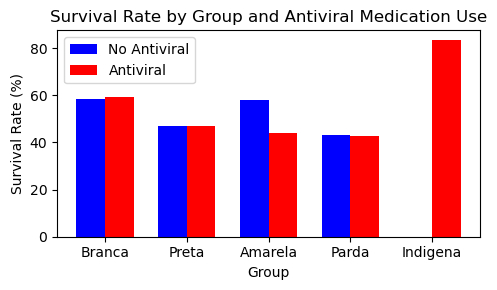

In [21]:
plot_stratified_antiviral_surv(df, groups=['Branca', 'Preta', 'Amarela', 'Parda', 'Indigena'])

Total Patients by Group:
Northeast: 714
North: 510
Southeast: 4929
Central-West: 105
South: 624


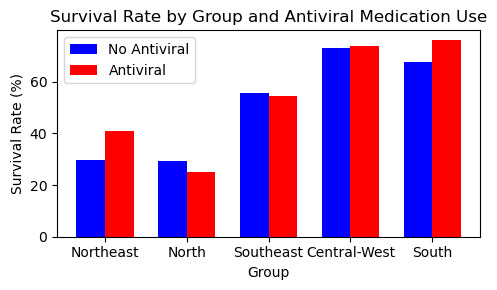

In [22]:
plot_stratified_antiviral_surv(df, groups=['Northeast', 'North', 'Southeast', 'Central-West', 'South'])

# Semi-synthetic Simulations

### 1. Treatment: Antiviral Medications -> Outcome: Survival

#### (A) General Scenario

In [24]:
from xgboost import XGBClassifier

TREATMENT = 'Antiviral_med'
OUTCOME = 'survived'

sim_df = df.copy()
sim_df = sim_df[((sim_df[TREATMENT] == 1) & (sim_df.Days_hosp_to_med < 1)) | (sim_df[TREATMENT] == 0)]
sim_df = sim_df[sim_df['Days_hospital_to_outcome'] > 0]

sim_df = sim_df.drop(columns=['Vent_invasive', 'Vent_noninvasive', 'FLU_Vaccine', 'ICU', 'Days_hosp_to_med', 'Days_hospital_to_outcome'])

# Separate the data into treatment groups
df_1 = sim_df[sim_df[TREATMENT] == 1]
df_0 = sim_df[sim_df[TREATMENT] == 0]
print(f"N0={len(df_0)}, N1={len(df_1)}")
print(f"Total N={len(df_0) + len(df_1)} (original N={len(df)})")

# Training XGBoost model for T=1
xgb_1 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_1.fit(df_1.drop(columns=[OUTCOME]), df_1[OUTCOME])

# Training XGBoost model for T=0
xgb_0 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_0.fit(df_0.drop(columns=[OUTCOME]), df_0[OUTCOME])

# Predict counterfactual outcomes for T=1 and convert to binary indicators
y1_proba = xgb_1.predict_proba(df_0.drop(columns=[OUTCOME]))[:, 1]
y1 = (y1_proba > 0.5).astype(int)
df_0.loc[:, 'y1'] = y1
df_0.loc[:, 'y0'] = df_0[OUTCOME]

# Predict counterfactual outcomes for T=0 and convert to binary indicators
y0_proba = xgb_0.predict_proba(df_1.drop(columns=[OUTCOME]))[:, 1]
y0 = (y0_proba > 0.5).astype(int)
df_1.loc[:, 'y0'] = y0
df_1.loc[:, 'y1'] = df_1[OUTCOME]

# Merge the results back into the original dataframe
sim_df = pd.concat([df_1, df_0])
sim_df = sim_df.drop(columns=['Antiviral_med', OUTCOME])

# Save
sim_df.to_csv(f"./parsed/covid_parsed.csv")
print(sim_df.shape)
print(sim_df.columns)
print("Yt Means\n", sim_df[['y0', 'y1']].mean())

N0=3335, N1=2591
Total N=5926 (original N=6882)
(5926, 31)
Index(['Sex_male', 'Age', 'Fever', 'Cough', 'Sore_throat',
       'Shortness_of_breath', 'Respiratory_discomfort', 'SPO2', 'Dihareea',
       'Vomitting', 'Cardiovascular', 'Asthma', 'Diabetis', 'Pulmonary',
       'Immunosuppresion', 'Obesity', 'Liver', 'Neurologic', 'Renal', 'Branca',
       'Preta', 'Amarela', 'Parda', 'Indigena', 'Northeast', 'North',
       'Southeast', 'Central-West', 'South', 'y0', 'y1'],
      dtype='object')
Yt Means
 y0    0.533750
y1    0.583868
dtype: float64
